<a href="https://colab.research.google.com/github/AnnJer/Practice_in_Data_Preprocessing/blob/master/nlp_routine2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
!pip install stop-words

  Created wheel for stop-words: filename=stop_words-2018.7.23-cp36-none-any.whl size=32916 sha256=f48e0582178d3e64fcd06ca1ea8f9ea7aa05f3efae4669a41927338ac4f2bdeb
  Stored in directory: /root/.cache/pip/wheels/75/37/6a/2b295e03bd07290f0da95c3adb9a74ba95fbc333aa8b0c7c78
Successfully built stop-words


In [0]:
import pandas as pd
from stop_words import get_stop_words
from keras.utils import to_categorical


from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import LabelBinarizer

from xgboost import XGBClassifier
import re
import matplotlib.pyplot as plt
plt.style.use('seaborn')
import seaborn as sns

Using TensorFlow backend.


In [0]:
from google.colab import drive 
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
data = pd.read_csv("/content/gdrive/My Drive/plot/wiki_movie_plots_deduped.csv")

print("Number of rows: {}, columns: {} in the dataset".format(*data.shape))
data.head()

Number of rows: 34886, columns: 8 in the dataset


,Release Year,Title,Origin/Ethnicity,Director,Cast,Genre,Wiki Page,Plot
0,1901,Kansas Saloon Smashers,American,Unknown,NaN,unknown,https://en.wikipedia.org/wiki/Kansas_Saloon_Sm...,"A bartender is working at a saloon, serving dr..."
1,1901,Love by the Light of the Moon,American,Unknown,NaN,unknown,https://en.wikipedia.org/wiki/Love_by_the_Ligh...,"The moon, painted with a smiling face hangs ov..."
2,1901,The Martyred Presidents,American,Unknown,NaN,unknown,https://en.wikipedia.org/wiki/The_Martyred_Pre...,"The film, just over a minute long, is composed..."
3,1901,"Terrible Teddy, the Grizzly King",American,Unknown,NaN,unknown,"https://en.wikipedia.org/wiki/Terrible_Teddy,_...",Lasting just 61 seconds and consisting of two ...
4,1902,Jack and the Beanstalk,American,"George S. Fleming, Edwin S. Porter",NaN,unknown,https://en.wikipedia.org/wiki/Jack_and_the_Bea...,The earliest known adaptation of the classic f...


Let`s delete unimportant columns

In [0]:
data = data.drop(["Release Year", "Title", "Origin/Ethnicity", "Director", "Cast", "Wiki Page"], axis = 1)

data.head(5)

,Genre,Plot
0,unknown,"A bartender is working at a saloon, serving dr..."
1,unknown,"The moon, painted with a smiling face hangs ov..."
2,unknown,"The film, just over a minute long, is composed..."
3,unknown,Lasting just 61 seconds and consisting of two ...
4,unknown,The earliest known adaptation of the classic f...


In [0]:
print("Genre column contains {} cells with whitespaces and {} null values ".format(data.Genre.str.isspace().sum(),
                                                                                data.Genre.isnull().sum()))
print("Plot column contains {} cells with whitespaces and {} null values".format(data.Plot.str.isspace().sum(), 
                                                                             data.Plot.isnull().sum()))

Genre column contains 28 cells with whitespaces and 0 null values 
Plot column contains 0 cells with whitespaces and 0 null values


After analysis the data, you need to delete the "unknown" values and whitespaces in "Genre".

In [0]:
data = data.drop(data[data.Genre.str.isspace()].index)
data = data.drop(data[data.Genre == "unknown"].index)

plot = data["Plot"]
label = data["Genre"]  

# data.drop(data.index, inplace=True) #delete data in dataframe

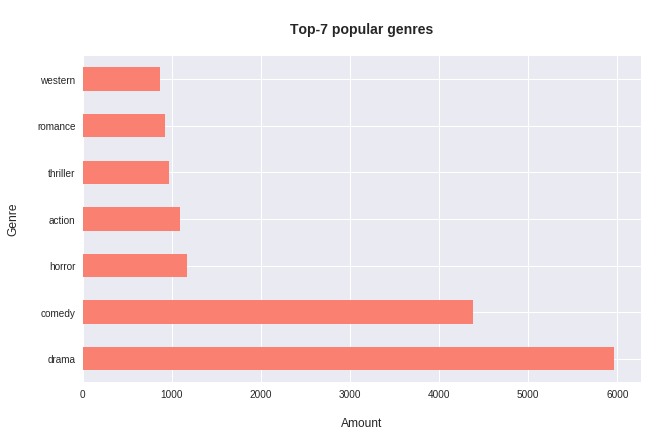

In [0]:
label.groupby(label).size().sort_values(ascending=False).head(7).plot(kind='barh', 
                figsize=(10,6), legend=False, color='salmon')
plt.xlabel('\nAmount', fontsize=12)
plt.ylabel('Genre\n', fontsize=12)
plt.title('\nTop-7 popular genres\n', fontsize=14, fontweight='bold');

First we will need to transform each element of labels before passing it to the MultiLabelBinarizer. Label needs to be cleaned from extra characters and separated by comma.  Let's push data processing into a separate classes.

In [0]:

class LabelPreprocessing(TransformerMixin):
    def __init__(self, *args, **kwargs):
        pass
    
    def fit(self,X ,y=None):
        super(LabelPreprocessing, self).fit(X)
        return self
    
    def transform(self, y, X=None):
        y = y.str.findall(r'([a-zA-Z]{3,})') 
        y = y.replace(regex=r'(film)', value=' ')
        return y.values
    
class PlotPreprocessing(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
        self.BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')

    def fit(self, X, y=None, **fit_params):
        return self

    def transform(self, X, y=None, **fit_params):
        X = X.str.lower()
        X = X.map(lambda x: re.sub(self.REPLACE_BY_SPACE_RE," ",x))
        X = X.map(lambda x: re.sub(r'\s+'," ",x))
        return X.values
    
    def fit_transform(self,y,X, **fit_params):
        self.fit(X,y)
        return self.transform(X,y)

In [0]:
newx = PlotPreprocessing().transform(X=plot)
tfidf = TfidfVectorizer(ngram_range=(1,2),max_df=0.9,min_df=5,token_pattern=r'(\S+)', stop_words=get_stop_words('en'))
ft = tfidf.fit(newx)
t = ft.transform(newx)

In [0]:
label_preprocessing = LabelPreprocessing().transform(label)

mlb = MultiLabelBinarizer()
matrix = mlb.fit_transform(label_preprocessing)

In [0]:
pipeline = Pipeline([
    ('plot', PlotPreprocessing())
    ,
    ('tfidf_vectorizer', TfidfVectorizer(ngram_range=(1,2),max_df=0.9,min_df=5,token_pattern=r'(\S+)'))
    ,
    ('model', LinearRegression())
])

train_X, train_y, test_X, test_y = train_test_split(plot, label)

pipeline.fit_predict(train_X, train_y)
y_pred = pipeline.predict( test_X ) 

As you might have noticed earlier, we a have a problem of multi-label classification here, because one movie can belongs to several genres concurrently. 

In [0]:
pipeline = Pipeline([
    (
'text_preparation', FeatureUnion([
    ('label', Pipeline([
        ('labelPreprocessing', LabelPreprocessing()),
        ('mlb', MLBinarizer())
    ])), 
    ('plot', PlotPreprocessing()
    )
  ])), 
  ('tfidf_vectorizer', TfidfVectorizer(ngram_range=(1,2),max_df=0.9,min_df=5,token_pattern=r'(\S+)')
  ),
  ('model', LinearRegression())
    
])

train_X, train_y, test_X, test_y = train_test_split(plot, label)

pipeline.fit(train_X, train_y)
y_pred = pipeline.predict( test_X ) 

In [0]:
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import TruncatedSVD
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

classifier = Pipeline([
    ('features', FeatureUnion([
        ('text', Pipeline([
            ('plot', PlotPreprocessing()),
            ('tfidf', TfidfVectorizer(
                     min_df=.0025, max_df=0.25, ngram_range=(1,3))),
            ('svd', TruncatedSVD(algorithm='randomized', n_components=300)), #for XGB
        ])),
        ('words', Pipeline([

            ('wscaler', StandardScaler()),
        ])),
    ])),
    ('clf', XGBClassifier(max_depth=3, n_estimators=300, learning_rate=0.1)),
#    ('clf', RandomForestClassifier()),
    ])

train_X, train_y, test_X, test_y = train_test_split(plot, label)

classifier.fit(train_X, train_y)
y_pred = classifier.predict( test_X ) 